In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import acos, sqrt, pi, cos, sin, exp, floor
from collections import defaultdict

def cvtGrayscale(img):
    if len(img.shape) < 3:
        return img
    b, l, c = img.shape
    gray = np.zeros((b,l), dtype = "int64")
    for i in range(b):
        for j in range(l):
            gray[i][j] = (0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2])
    return gray

def padding(img, k, fill):
    b, l, c = img.shape
    out = np.zeros((b+2*(k//2), l+2*(k//2), c), dtype="int64")
    out[k//2:b+k//2, k//2:l+k//2, 0:3] = img
    if fill == 0:
        pass
    elif fill == 1: 
        out[0:k//2,0:l + 2*(k//2), 0:3] = 255
        out[b+k//2:b + 2*(k//2),0:l + 2*(k//2), 0:3] = 255
        out[k//2:b+k//2, 0:k//2, 0:3] = 255
        out[k//2:b+k//2, l + k//2: l + 2*(k//2), 0:3] = 255
    else:
        return -1
        
    return out

## Q4) Consider the image roads.jpg and solve the following:

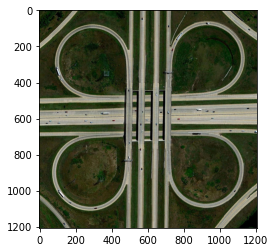

In [3]:
img_roads = cv2.imread('../images/roads.jpg')
img_roads = cv2.cvtColor(img_roads, cv2.COLOR_BGR2RGB)
plt.imshow(img_roads)

### 1. Show the outline of the vertically oriented middle carriageways which are not connected to the circle like interchanges. Refer figure 2a.

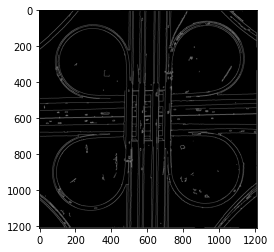

In [4]:
def colorgaussian(img, k, sigma):
    img = padding(img, k, 0)
    b, l, _ = img.shape
    out = np.copy(img)
    kernel = np.zeros((k,k))
    s = 2*(sigma**2)
    for i in range(k):
        for j in range(k):
            kernel[i][j] = (1/pi*s)*(exp((-1)*((((i-k//2)**2) + ((j-k//2)**2))/s)))
    #print(kernel)
    kernel *= 1/(kernel[0][0])
    
    for i in range(k):
        for j in range(k):
            kernel[i][j] = floor(kernel[i][j])
    kernel /= np.sum(kernel)
    
    for i in range(k//2,(b-(k//2))):
        for j in range(k//2,(l-(k//2))):
            for c in range(3):
                p= k//2
                if k != 1:
                    tmp = img[i-p:i+p+1,j-p:j+p+1,c:c+1].reshape(k,k)
                else:
                    tmp = img[i][j][c]
                out[i][j][c] = floor(np.sum(tmp*kernel))
            
    return out

img_roads = colorgaussian(img_roads,5,0.8)
edge_img = cv2.Canny(img_roads.astype(np.uint8), 100, 270)
plt.imshow(edge_img, cmap='gray')

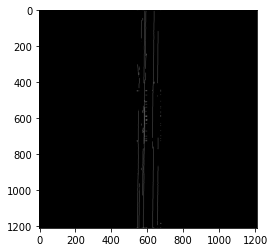

In [4]:
def hough2D(edges):
    b, l = edges.shape
    d = np.sqrt(b**2 + l**2)
    mags = np.arange(-d, d, 0.5)
    thetas = np.arange(0,180,1)
    acc = np.zeros((len(mags),len(thetas)))
    for i in range(b):
        for j in range(l):
            if edges[i][j] != 0:
                x = i-b//2
                y = j-l//2
                for theta in range(180):
                    mag = x*cos(theta/pi) + y*sin(theta/pi)
                    mag_ind = np.argmin(np.abs(mags - mag))
                    acc[mag_ind][theta] += 1
    return acc

def findstr(img, acc, t):
    b, l = img.shape
    d = np.sqrt(b**2 + l**2)
    out = np.zeros(img.shape)
    mags = np.arange(-d, d, 0.5)
    thetas = np.arange(0,180,1)
    for i in range(acc.shape[0]):
        for j in range(0,1):
            if acc[i][j] > t:
                c = np.cos(np.deg2rad(j))
                s = np.sin(np.deg2rad(j))
                mag = mags[i]
                x0 = floor((c * mag) + l//2)
                if x0 in range(520,680):
                    for k in range(b):
                        if img[k][x0] != 0:
                            out[k][x0] = 255
                        elif img[k][x0+1] != 0:
                            out[k][x0+1] = 255
    return out

plt.imshow(findstr(edge_img,hough2D(edge_img),70), cmap='gray')

In [5]:
acc = hough2D(edge_img)
print(acc[np.where(acc[:,0] != 0)])

[[ 836.   22.   10. ...   24.   11.    7.]
 [  19.   14.    6. ...   23.   12.    8.]
 [  33.   20.    5. ...   18.   12.   22.]
 ...
 [  20.   10.   24. ...   14.   17.    9.]
 [1044.   10.   29. ...   12.   16.    9.]
 [   2.   10.   14. ...   14.   13.    8.]]


### 2. Display the best fitting circle for each of the circle-like interchanges and output the radius of each in pixels.

In [ ]:
def hough3D(edges):
    b,l = edges.shape
    d = np.sqrt(b**2 + l**2)
    thetas = np.arange(0,360,0.5)
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    radii = np.arange(0,d,0.5)
    
    circle_candidates = []
    for r in radii:
        for t in range(len(thetas)):
            circle_candidates.append((r, int(r * cos_thetas[t]), int(r * sin_thetas[t])))
    
    acc = defaultdict(int)
    
    for i in range(b):
        for j in range(200,1000):
            if edges[i][j] != 0:
                for r, rcos_t, rsin_t in circle_candidates:
                    x_center = j - rcos_t
                    y_center = i - rsin_t
                    acc[(x_center,y_center,r)] += 1
      
    for candidate_circle, votes in sorted(acc.items(), key=lambda i: -i[1]):
        x, y, r = candidate_circle
        current_votes = votes
        if current_votes >= 200: 
            print(x, y, r, current_votes)

print(hough3D(edge_img))
#Didn't run ran out of memory
